# Preprocess Lithium Carbonate 99%Min China Spot Historical Data
Lithium Carbonate (Li2CO3) 99% Min China Spot:
- File: Lithium Carbonate 99%Min China Spot Historical Data.csv
- Source: Investing.com
- URL: https://www.investing.com/commodities/lithium-carbonate-99-min-china-futures-historical-data
- Currency: CNY
- Date: 2017-05-10 to 2023-08-29

I use the data of Lithium Carbonate from investing.com as lithium prices instead of the two from Wind since we have no access more information from Wind Database. Lithium Carbonate price from investing.com is update with currency specified. We still need lithium hydroxide price later and currently there is no public data available.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

## Data Cleaning

Text(0.5, 1.0, 'Lithium Carbonate 99%Min China Spot (investing.com)')

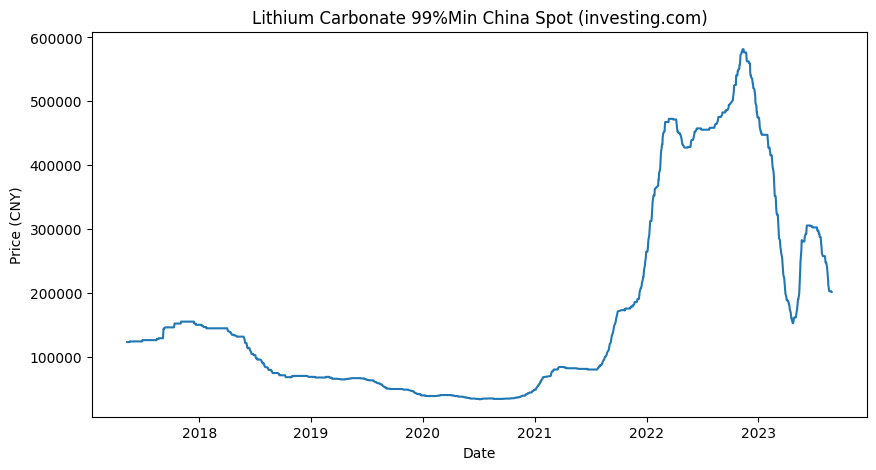

In [48]:
def investing_data(filename):
    '''
    Clean csv from investing.com
    Input filename 
    Output cleaned dataframe
    '''
    df = pd.read_csv('./Data/'+filename, usecols=[0,1])

    # Convert price column to numeric
    df['Price'] = df['Price'].apply(lambda s: float(str(s).replace(',', ''))) 

    # Set datetime as index and sort from earliest to latest
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date').sort_index()

    return df

ltcb = investing_data('Lithium Carbonate 99%Min China Spot Historical Data.csv')

fig = plt.figure(figsize = (10,5))
plt.plot(ltcb['Price'])
plt.xlabel('Date')
plt.ylabel('Price (CNY)')
plt.title('Lithium Carbonate 99%Min China Spot (investing.com)')

## Check Zeros

Text(0.5, 1.0, 'Monthly Zero Daily Return Ratio of Lithium Carbonate 99%Min')

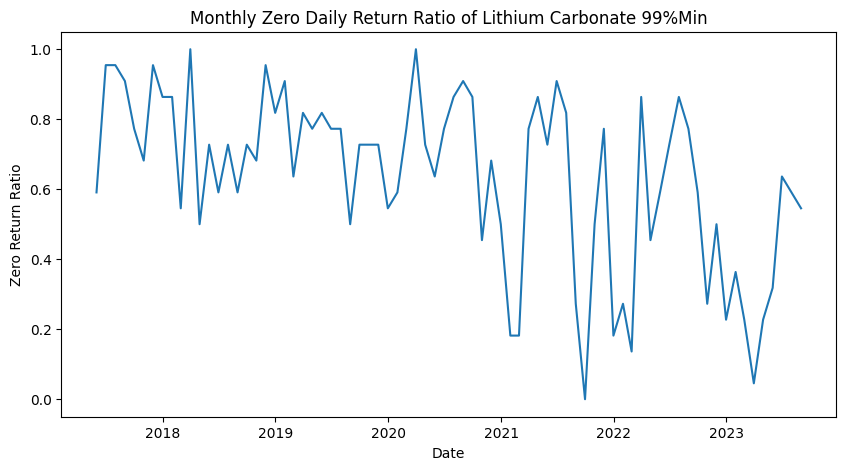

In [49]:
def zeros(df):
    '''
    Calculate daily log return and flag the zeros
    '''
    df['Daily'] = np.log(df['Price']).diff() # Daily return
    df['Daily'].replace([np.inf, -np.inf], np.NaN, inplace = True)
    df['Zeros'] = (df['Daily'] == 0).astype(int)

    z = df['Zeros'].resample('M').sum() / 22

    df.drop(columns = ['Daily','Zeros'], inplace = True)
    return z.to_frame()

monthly_zeros = zeros(ltcb)

fig = plt.figure(figsize = (10,5))
plt.plot(monthly_zeros)
plt.xlabel('Date')
plt.ylabel('Zero Return Ratio')
plt.title('Monthly Zero Daily Return Ratio of Lithium Carbonate 99%Min')

## Friday-to-Friday Log Return

Text(0.5, 1.0, 'LTCB Fri-to-Fri Log Return')

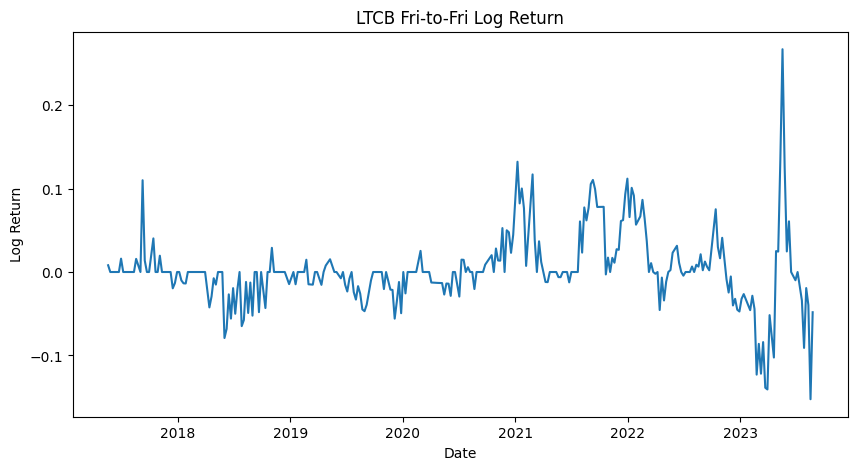

In [50]:
def dayofweek_return(df, day): 
    '''
    Select day of week data from dataframe
    Input dataframe, dayofweek (0-4)
    Output log return of dayofweek
    '''
    df_select = df[df.index.dayofweek == day].copy() # Select certaiin dayofweek
    df_select['Return'] = np.log(df_select['Price']).diff() # Weekly return
    df_select = df_select.drop(columns = ['Price'])
    return df_select.tail(-1) # Delete first row with NaN value

fig = plt.figure(figsize = (10,5))
plt.plot(dayofweek_return(ltcb, 4))
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.title('LTCB Fri-to-Fri Log Return')

## Unsmoothing with Autoregressive Model

Given $$r_t = \mu + e_t \ \text{and}\  r_t^o = (1-\theta) r_t + \theta r_{t-1}^o $$
We have $$ r_t = \mu + \theta (r_{t-1}^o - \mu) + (1-\theta) e_t$$

Run regression on $$ \hat{r}_t^o = a + b\hat{r}_{t-1}^o + \epsilon_t$$
Then $$ \hat{\theta} = \hat{b},\ \hat{\mu} = \frac{\hat{a}}{1-\hat{b}}, \ \hat{e}_t = \frac{\hat{\epsilon}_t}{1-\hat{b}} $$
Thus $$ \hat{r}_t = \hat{\mu} + \hat{e}_t $$

In [51]:
def get_lag(df, lag):
    '''
    Create lag columns
    Input: dataframe (dayofweek_return result), positive integer lag
    Output: dataframe with lag
    '''

    temp = df.copy()
    for i in range(1,lag+1):
        temp[f'Lag_{i}'] = temp['Return'].shift(i) # lag i column

    return temp.tail(-lag) # Remove first i row (shift generates NaN)

fri = get_lag(dayofweek_return(ltcb, 4), 1)

In [52]:
def ar_unsmooth(df):
    '''
    Data unsmoothing
    Input dataframe (Result of dayofweek_return)
    Output dataframe with column Lag1, Error, True (return)
    '''
    X = df['Lag_1'] # observed r at t-1 as X
    X = sm.add_constant(X)
    y = df['Return'] # observed r at t as y

    # Run OLS regression
    model = sm.OLS(y, X).fit() 
    a_hat = model.params.const
    b_hat = model.params.Lag_1
    print(model.summary())

    # ar1 = ARIMA(endog=df['Return'], order=(1,0,0)).fit()
    # a_hat = ar1.params['const']
    # b_hat = ar1.params['ar.L1']
    # print(ar1.summary())


    # Calculate true return
    df['Residual'] = df['Return'] - (a_hat + b_hat * df['Lag_1'])
    df['True_AR'] = a_hat / (1 - b_hat) + df['Residual'] / (1 - b_hat) # Store as True_AR
    # df['True_AR_modified']

    # Delete error column
    df.drop(columns = 'Residual', inplace = True)

ar_unsmooth(fri)

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     316.1
Date:                Mon, 11 Sep 2023   Prob (F-statistic):           1.28e-48
Time:                        12:50:47   Log-Likelihood:                 618.49
No. Observations:                 298   AIC:                            -1233.
Df Residuals:                     296   BIC:                            -1226.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.184      0.8

In [53]:
# fri['True_AR'].to_csv('./Data/LTCB_AR_true.csv')

Text(0.5, 1.0, 'LTCB Fri-to-Fri Observed vs True')

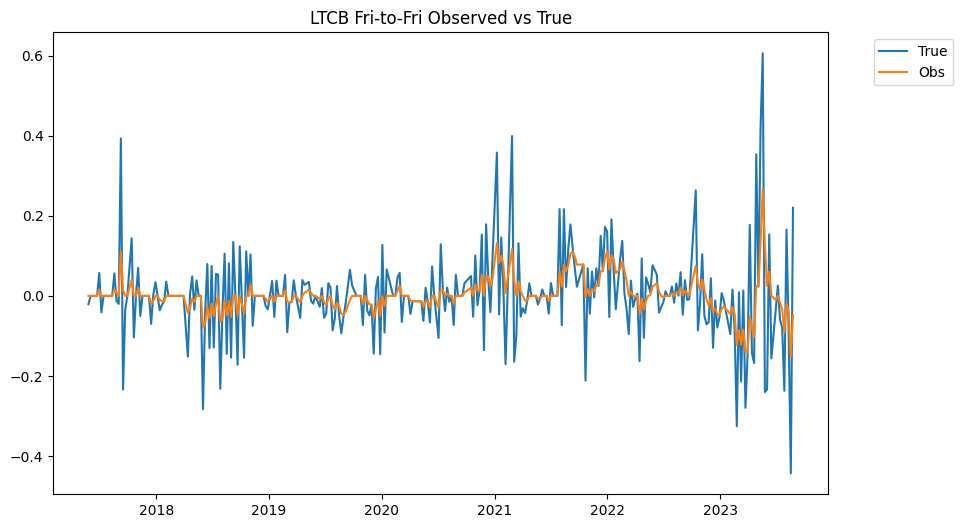

In [54]:
# Compare r_t observed and r_t
fig = plt.figure(figsize = (10,6))
plt.plot(fri['True_AR'], label = 'True')
plt.plot(fri['Return'], label = 'Obs')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('LTCB Fri-to-Fri Observed vs True')

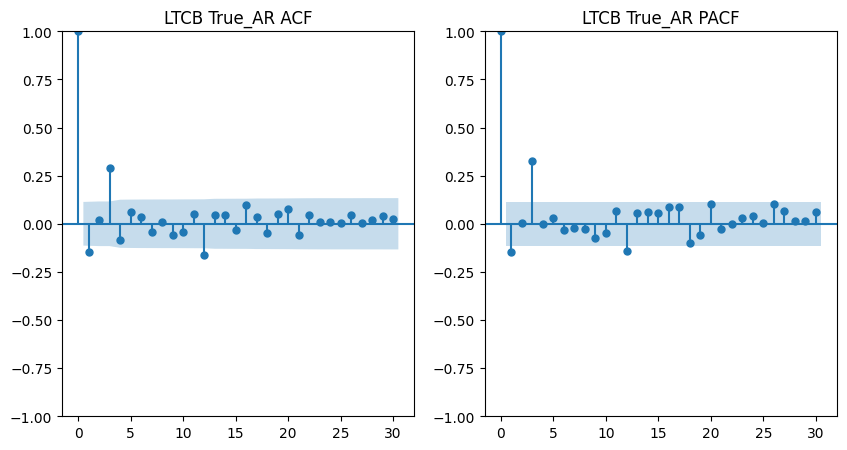

In [55]:
# Check autocorrelation
def autocorr(df, col): 
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    plot_acf(df[col], lags=30, alpha = 0.05, title = 'LTCB ' + col + ' ACF', ax=ax[0])
    plot_pacf(df[col], lags=30, alpha = 0.05, method = 'ols', title = 'LTCB ' + col + ' PACF', ax=ax[1])

autocorr(fri, 'True_AR')

In [56]:
fri['True_AR'].describe() # Mean and standard deviation

count    298.000000
mean       0.001160
std        0.108713
min       -0.442963
25%       -0.042507
50%        0.000000
75%        0.037979
max        0.605763
Name: True_AR, dtype: float64

In [57]:
fri[['Return','True_AR']].corr() # Correlation

,Return,True_AR
Return,1.000000,0.695381
True_AR,0.695381,1.000000


## Unsmoothing with Moving Average Model

Given $ r_t^o = \theta_0 r_t + \theta_1 r_{t-1} + \cdots + \theta_n r_{t-n}$ and $\sum_{k=0}^h \theta_k = 1 $. **I am not sure what to ensure sum of theta is 1** </br>
Insert $ r_t = \mu + e_t $ </br>

MA(h) process: $$ r_t^o = \mu + \sum_{k=0}^h \theta_k e_{t-k} $$

If we assume $ e_t \sim H(0, \sigma^2) $, Can be easily estimated by MLE when the initial residuals are set to zero

More that existing MLE estimate MA(h) process under a different normalization
$$ r_t^o = \mu + \epsilon_t + \sum_{k=1}^h \alpha_k \epsilon_{t-k} $$
So that the coefficient on $\epsilon_t$ is normalized to 1.

It is ok to estimate this system and then re-normalize:
Let $$ \begin{cases} \hat{\alpha} = 1 + \sum_{k=1}^h \alpha k \\ \hat{e}_t = \epsilon_t \hat{\alpha} ,\quad \hat{e}_{t-k} = \epsilon_{t-k} \hat{\alpha} \\ \hat{\theta} = \frac{1}{\hat{\alpha}} ,\quad \hat{\theta}_k = \frac{\hat{\alpha}_k}{\hat{\alpha}}\end{cases} $$

Once the system is estimated, the residuals can be recursively filled in: $$ \hat{e}_t = r_t^o - \mu -\sum_{k=1}^h \hat{\theta}_k \hat{e}_{t-k} $$
and $$\hat{r}_t = \mu + \hat{e}_t $$

Because we left the lag-length unspecified, we must find a way to tie it clean. We can use the AIC on BIC criterion estimating the model for $h=0,1,2,3$ and picking the model that minimizes this criterion.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                  298
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 579.769
Date:                Mon, 11 Sep 2023   AIC                          -1153.538
Time:                        12:50:48   BIC                          -1142.447
Sample:                             0   HQIC                         -1149.098
                                - 298                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.501      0.616      -0.005       0.008
ma.L1          0.6165      0.029     21.064      0.000       0.559       0.674
sigma2         0.0012   5.95e-05     20.055      0.0

Text(0.5, 1.0, 'LTCB Fri-to-Fri Observed vs True')

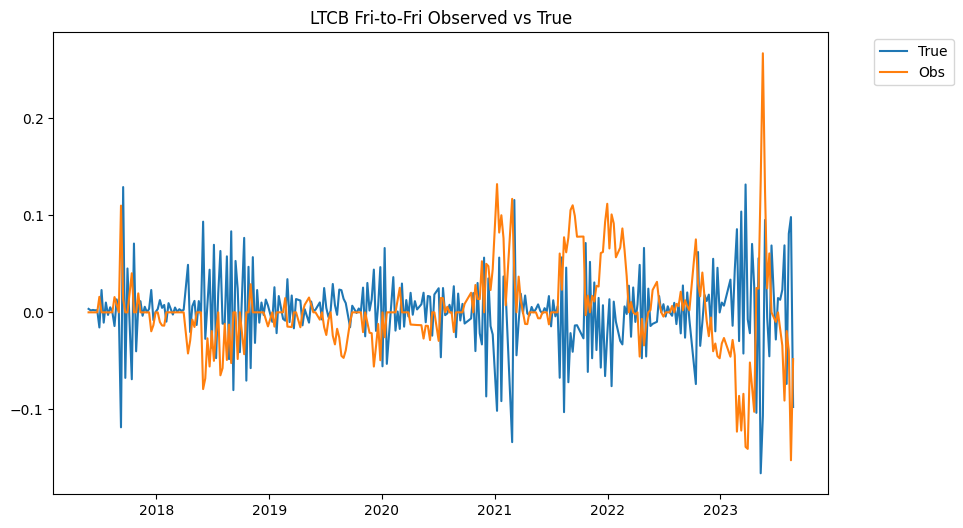

In [58]:
from scipy.stats import norm
from scipy.optimize import minimize 

ma_try = fri.copy()
ma1 = ARIMA(endog=ma_try['Return'], order=(0,0,1)).fit()
print(ma1.summary())
res = ma1.resid
std = np.std(res)

def mle_norm(params):
   mu, theta, std = params
   pred = mu + theta * res
   
   return -1 * np.sum(norm.logpdf(fri['Return'], loc = pred, scale = std))

mle_model = minimize(mle_norm, ma1.params[:2].to_list() + [std], method = 'Nelder-Mead')

# Estimate the system
alpha_hat = 1 + np.sum(mle_model.x[1:-1])
e = alpha_hat * res
theta = [1/alpha_hat] + mle_model.x[1:-1] / alpha_hat
e_t = fri['Return'] - mle_model.x[0] - theta * e

# Final result
fri['True_MA1'] = mle_model.x[0] + e_t

fig = plt.figure(figsize = (10,6))
plt.plot(fri['True_MA1'], label = 'True')
plt.plot(fri['Return'], label = 'Obs')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('LTCB Fri-to-Fri Observed vs True')

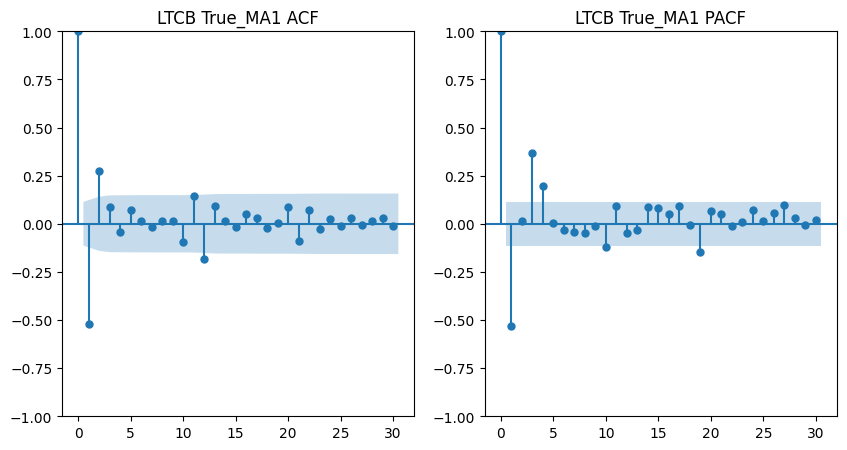

In [59]:
def autocorr(df, col): 
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    plot_acf(df[col], lags=30, alpha = 0.05, title = 'LTCB ' + col + ' ACF', ax=ax[0])
    plot_pacf(df[col], lags=30, alpha = 0.05, method = 'ols', title = 'LTCB ' + col + ' PACF', ax=ax[1])

autocorr(fri, 'True_MA1')